# Interpolation in a cleaned-up notebook

In [1]:
import os
import jax
import jax.numpy as jnp
from scipy.io import savemat
import matplotlib.pyplot as plt

from timeit import default_timer
import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

from examples.wave_scattering_utils import (
    solve_scattering_problem,
    load_SD_matrices,
    get_uin,
)
from examples.scattering_potentials import (
    q_gaussian_bumps,
)
from examples.plotting_utils import plot_field_for_wave_scattering_experiment

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)

2025-06-26 14:06:22.205:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-26 14:06:22.206:jaxhps: DEBUG - Creating converter from 5 to 7
2025-06-26 14:06:22.206:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-26 14:06:22.207:jaxhps: DEBUG - Creating converter from 5 to 7


In [2]:
from jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from jaxhps.merge import merge_stage_uniform_2D_ItI
from jaxhps.down_pass import down_pass_uniform_2D_ItI
from examples.wave_scattering_utils import (
    get_DtN_from_ItI,
    setup_scattering_lin_system,
    get_uin_and_normals,
    get_uin,
    get_scattering_uscat_impedance,
)
from src.jaxhps import (
    Domain as MyDomain,
    DiscretizationNode2D as MyDiscretizationNode2D
)
from jaxhps._grid_creation_2D import (
    rearrange_indices_ext_int as rearrange_indices_ext_int_2D,
)
from jaxhps.quadrature import (
    barycentric_lagrange_interpolation_matrix_1D,
    barycentric_lagrange_interpolation_matrix_2D,
    chebyshev_points,
)

from rlc_repo_link.src.data.data_transformations import (
    prep_conv_interp_2d,
    apply_interp_2d,
    # Maybe I could leverage the separability to use the 1d operators?
    prep_conv_interp_1d,
    apply_interp_1d,
)

INTERP_BATCH_SIZE = 20

## Functions

In [3]:
def reorder_leaves_indices(L: int, s: int = 1, new_order: tuple=(3,2,0,1)):
    """This function prepares the indices needed to recursively perform the 
    reordering operation as described below:

    Suppose the inputs have children in labeled as [0,1,2,3]
        +-----+-----+-----+-----+
        |  0  |  1  |  2  |  3  |
        +-----+-----+-----+-----+
    This function will re-order the children within the flattened structure.
    For example, setting new_order=(3,2,0,1) would result in
        +-----+-----+-----+-----+
        |  3  |  2  |  0  |  1  |
        +-----+-----+-----+-----+
    which, in the quadtree, corresponds to an spatial organization of
        +-----+-----+
        |  3  |  2  |
        +-----+-----+
        |  0  |  1  |
        +-----+-----+
    in terms of the input.
    Note: this function can be used to put the quadtree into Morton or Z order, but this
    is different from row-major order, as far as the blocks are concerned.

    Parameters:
        L (int): number of levels in the quadtree
        s (int): number of entries per leaf in the quadtree
        new_order (tuple of ints): new relative ordering of the leaves
    Output:
        idcs (jax.array): re-ordered leaf index map with shape (4**L * s**2,)
            Can be used as jax.take(leaf_data, idcs, axis=<relevant axis>)
    """
    idcs = jnp.arange(4**L * s)
    new_order_array = jnp.array(new_order)
    for l in range(0, L):
        idcs = idcs.reshape(4**l, 4, 4**(L-l-1))
        idcs = jnp.take(idcs, new_order_array, axis=1)
    return idcs

def morton_to_flatten_indices(L: int, s: int, return_flat=True):
    """Converts the indices for morton ordering into a flattened structure
    Largely lifted from Matt Li's code; for my purposes s=1 seems sufficient
    """
    if L==0:
        res = jnp.arange(s**2).reshape(s,s) # no re-ordering necessary
    else:
        bsize = 4**(L-1) * s**2 # block size
        tmp = morton_to_flatten_indices(L-1, s, return_flat=False) # recurrence
        res = jnp.block([[tmp, tmp+bsize], [tmp+2*bsize, tmp+3*bsize]])
    return res.flatten() if return_flat else res

def prep_quadtree_to_unrolled_indices(L: int, s=1, new_order=(0,1,3,2)):
    """Prepares the indices needed to go from the quadtree ordering of
        +-----+-----+
        |  0  |  1  |
        +-----+-----+
        |  3  |  2  |
        +-----+-----+
    to an unrolled ordering based on the spatial layout:
        [[0 1 2   ... 2^L-1]
         [1+2^L   ...      ]
         [        ...      ]
         [4^L-2^L ... 4^L-1]
    Parameters:
        L (int): number of levels in the quadtree
        s (int): number of elements per level in the quadtree
        new_order (tuple): the new ordering of the blocks
            default:   (0,1,3,2)
            alternate: (3,2,0,1) (depends on the desired first-axis ordering)
    """
    quadtree_to_morton   = reorder_leaves_indices(L, s, new_order=new_order)
    morton_to_unrolled   = morton_to_flatten_indices(L, s)
    quadtree_to_unrolled = jnp.take(quadtree_to_morton, morton_to_unrolled)
    return quadtree_to_unrolled

def apply_quadtree_to_unrolled_indices(data: jax.Array, quadtree_to_unrolled: jax.Array, axis=0):
    """Super basic function to apply the indices, mostly for a reminder of the usage"""
    return jnp.take(data, quadtree_to_unrolled, axis=axis)

In [4]:
# Quadtree (Chebyshev) -> Uniform
class QuadtreeToUniform:
    """Class to interpolate data from quadtree form with chebyshev-grid leaves
    to a contiguous form on a uniform grid.
    Simplifying assumptions:
    1. Assume each leaf contains an integer number of points from the uniform grid,
    and that these points are always in the same positions relative to the leaf boxes
    2. Assume that the domain size does not change
    """
    def __init__(self, L: int, p: int, n_per_leaf: int, cell_offset: float = 0):
        """Set up the reusable objects
        Parameters:
            L (int): number of levels in the tree
            p (int): polynomial order of the leaf-level chebyshev grids 
            n_per_leaf (int): number of points in the uniform grid per leaf
            cell_offset (float): relative offset of where to sample the uniform grid
                If a leaf's chebyshev grid is sampled on the interval [-1, 1],
                the cell_offset values correspond to the following behavior:
                0:   default behavior, sample at    [0, 1, 2, ..., n_per_leaf-1]*2/n_per_leaf-1
                0.5: cell-centered, sample at       [0.5, 1.5, 2.5, ..., n_per_leaf-0.5]*2/n_per_leaf-1
                1:   sample on the opposite end, at [1, 2, ..., n_per_leaf]*2/n_per_leaf-1
        """
        self.L = L
        self.p = p
        self.n_per_leaf = n_per_leaf

        self.quadtree_to_unrolled_idcs = prep_quadtree_to_unrolled_indices(L)
        self.leaf_cheb_x = chebyshev_points(p)
        self.leaf_cheb_y = chebyshev_points(p)[::-1]

        self.cell_offset = cell_offset
        leaf_offset = cell_offset * 0.5/n_per_leaf
        self.leaf_unif_x = leaf_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False)
        self.leaf_unif_y = leaf_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False) # [::-1]

        tmp_interp_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
            from_pts_x=self.leaf_cheb_x,
            from_pts_y=self.leaf_cheb_y,
            to_pts_x=self.leaf_unif_x,
            to_pts_y=self.leaf_unif_y,
        )
        self.rearrange_leaf_idcs = rearrange_indices_ext_int_2D(p)
        self.interp_leaf_cheb_to_unif = tmp_interp_leaf_cheb_to_unif[:, self.rearrange_leaf_idcs]

    def apply(self, data_quadtree_cheb: jax.Array) -> jax.Array:
        """Applies the quadtree chebyshev-to-uniform operation
        Parameters:
            data_quadtree_cheb (jax.Array, shape: (4**L, p**2, ...)):
                Data from the HPS quadtree, sampled on Chebyshev grids at the leaf level
        Output:
            data_unif (jax.Array, shape (2**L * n_per_leaf, 2**L * n_per_leaf), ...):
                Data on the uniform grid without the quadtree structure
        """
        L = self.L
        p = self.p
        n_per_leaf = self.n_per_leaf
        leftover_shape = data_quadtree_cheb.shape[2:]
        leftover_idcs = 4 + jnp.arange(0, data_quadtree_cheb.ndim-2)

        # 1. Reorder the leaf nodes to a more standard ordering (~block-wise row-major-order)
        data_leaves_cheb = jnp.take(
            data_quadtree_cheb,
            self.quadtree_to_unrolled_idcs,
            axis = 0,
        )

        # 2. Map values from Chebyshev to Uniform grids on the leaf-level
        data_leaves_unif = jnp.einsum(
            "jl,il...->ij...",
            self.interp_leaf_cheb_to_unif,
            data_leaves_cheb
        )

        # 3. Reshape leaf-level data into square matrices, then rearrange
        data_unif = (
            data_leaves_unif
            .reshape(2**L, 2**L, n_per_leaf, n_per_leaf, *leftover_shape)
            .transpose(0,3,1,2, *leftover_idcs)
            .reshape(2**L * n_per_leaf, 2**L * n_per_leaf, *leftover_shape)

            # I don't know why the outputs need to be transposed here...
            .transpose(1,0, *(leftover_idcs-2))
        )
        return data_unif

In [5]:
# Uniform -> Quadtree (Chebyshev)
class UniformToQuadtree:
    """Class to interpolate data from a contiguous uniform grid to
    a quadtree form with chebyshev-grid leaves. Uses bicubic interpolation.
    Simplifying assumptions:
    1. Assume each leaf contains an integer number of points from the uniform grid,
    and that these points are always in the same positions relative to the leaf boxes
    2. Assume that the domain size does not change
    For now, fix it at [-1, 1, -1, 1] for both input/output since the true scaling does
    not really matter, other than if the domain were non-square.
    """
    def __init__(self, L: int, p: int, n_per_leaf: int, cell_offset: float = 0):
        """Set up the reusable objects
        Parameters:
            L (int): number of levels in the tree
            p (int): polynomial order of the leaf-level chebyshev grids 
            n_per_leaf (int): number of points in the uniform grid per leaf
            cell_offset (float): relative offset of where to sample the uniform grid
                If a leaf's chebyshev grid is sampled on the interval [-1, 1],
                the cell_offset values correspond to the following behavior:
                0:   default behavior, sample at    [0, 1, 2, ..., n_per_leaf-1]*2/n_per_leaf-1
                0.5: cell-centered, sample at       [0.5, 1.5, 2.5, ..., n_per_leaf-0.5]*2/n_per_leaf-1
                1:   sample on the opposite end, at [1, 2, ..., n_per_leaf]*2/n_per_leaf-1
        """
        self.L = L
        self.p = p
        self.n_per_leaf = n_per_leaf
        n = 2**L * n_per_leaf
        self.n = n

        # permutation maps for ordering leaves and chebyshev points within the leaves
        self.quadtree_to_unrolled_idcs = prep_quadtree_to_unrolled_indices(L, new_order=(0,1,3,2))
        self.unrolled_to_quadtree_idcs = jnp.argsort(self.quadtree_to_unrolled_idcs) # invert
        self.rearrange_leaf_idcs       = rearrange_indices_ext_int_2D(p)
        self.inv_rearrange_leaf_idcs   = jnp.argsort(self.rearrange_leaf_idcs) # invert

        # leaf-level grids, for simplicity scaled on [-1, 1]
        self.leaf_cheb_x = chebyshev_points(p)
        self.leaf_cheb_y = chebyshev_points(p)[::-1]
        leaf_offset = cell_offset * 0.5/n_per_leaf
        self.leaf_unif_x = leaf_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False)
        self.leaf_unif_y = leaf_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False) # [::-1]

        # tree-level grids, also scaled on [-1, 1]
        tree_offset = cell_offset * 0.5/n
        self.tree_unif_x = tree_offset+jnp.linspace(-1, 1, n, endpoint=False)
        self.tree_unif_y = tree_offset+jnp.linspace(-1, 1, n, endpoint=False)
        leaf_to_tree = lambda xs: jnp.concatenate([
            (xs+1) * (1/2**L) - 1 + (2*i/2**L)
            for i in range(2**L)
        ])
        self.tree_cheb_x = leaf_to_tree(self.leaf_cheb_x)
        self.tree_cheb_y = leaf_to_tree(self.leaf_cheb_y)

        # product grids
        product_grid = lambda xs, ys: jnp.array(jnp.meshgrid(xs, ys, indexing="ij")).transpose(1,2,0).reshape(-1,2)
        self.leaf_cheb_xy = product_grid(self.leaf_cheb_x, self.leaf_cheb_y)
        self.leaf_unif_xy = product_grid(self.leaf_unif_x, self.leaf_unif_y)
        self.tree_unif_xy = product_grid(self.tree_unif_x, self.tree_unif_y)
        self.tree_cheb_xy = product_grid(self.tree_cheb_x, self.tree_cheb_y)

        # Try to get the hps tree ordering
        self.hps_tree_cheb_xy = (
            self.tree_cheb_xy
            .reshape(2**L, p, 2**L, p, 2)
            .transpose(2, 0, 1, 3, 4)
            .reshape(4**L, p**2, 2)
            [self.unrolled_to_quadtree_idcs, :, :]
            [:, self.rearrange_leaf_idcs, :]
            .reshape(-1, 2)
        )

        # Interpolation operation, tree-wide
        self.tree_unif_to_cheb_x, self.tree_unif_to_cheb_y = prep_conv_interp_2d(
            tree_unif_x,
            tree_unif_y,
            # tree_domain.interior_points.reshape(-1,2),
            # tree_cheb_xy,
            self.hps_tree_cheb_xy,
            # use a zero-valued boundary condition to mimic empty neighboring leaves
            bc_modes=("zero", "zero"),
        )
        # Should/can I move the interpolation operators to the GPU?

    def apply(self, data_unif: jax.Array) -> jax.Array:
        """Take the data on the uniform grid, then map to the HPS quadtree format with leaf-level chebyshev grids
        Assume data_unif has shape (N, N)
        """
        L = self.L
        p = self.p
        n_per_leaf = self.n_per_leaf
        N = 2**L * n_per_leaf
        leftover_shape = data_unif.shape[2:]
        leftover_idcs  = 4 + jnp.arange(0, data_unif.ndim-2)

        data_tree_cheb = apply_interp_2d(
            self.tree_unif_to_cheb_x,
            self.tree_unif_to_cheb_y,
            data_unif.reshape(N, N),
        ).reshape(4**L, p**2)
        return data_tree_cheb

In [6]:
q_fn_handle = lambda x: q_gaussian_bumps(0.75 * x)

tree_n_per_leaf = 16
tree_L = 2
tree_p = 16
tree_n = 2**tree_L * tree_n_per_leaf

domain_bounds = jnp.array([-1., 1., -1., 1.])
tree_root = DiscretizationNode2D(*domain_bounds)
tree_domain = Domain(p=tree_p, q=tree_p-2, root=tree_root, L=tree_L)

print(f"L={tree_L}, N={tree_n}")

L=2, N=64


In [7]:
leaf_cheb_x = chebyshev_points(tree_p)
leaf_cheb_y = chebyshev_points(tree_p)[::-1]
leaf_to_tree = lambda xs: jnp.concatenate([
    (xs+1) * (1/2**tree_L) - 1 + (2*i/2**tree_L)
    for i in range(2**tree_L)
])
tree_cheb_x = leaf_to_tree(leaf_cheb_x)
tree_cheb_y = leaf_to_tree(leaf_cheb_y)

cell_offset = 0 # 0.5 for centered
leaf_unif_x = (cell_offset/tree_n_per_leaf)+jnp.linspace(-1, 1, tree_n_per_leaf, endpoint=False)
leaf_unif_y = (cell_offset/tree_n_per_leaf)+jnp.linspace(-1, 1, tree_n_per_leaf, endpoint=False) # [::-1]
tree_unif_x = (cell_offset/tree_n)+jnp.linspace(-1, 1, tree_n, endpoint=False)
tree_unif_y = (cell_offset/tree_n)+jnp.linspace(-1, 1, tree_n, endpoint=False)

product_grid = lambda xs, ys: jnp.array(jnp.meshgrid(xs, ys, indexing="ij")).transpose(1,2,0).reshape(-1,2)
leaf_cheb_xy = product_grid(leaf_cheb_x, leaf_cheb_y)
leaf_unif_xy = product_grid(leaf_unif_x, leaf_unif_y)
tree_unif_xy = product_grid(tree_unif_x, tree_unif_y)
tree_cheb_xy = product_grid(tree_cheb_x, tree_cheb_y)

In [8]:
%time
QtU = QuadtreeToUniform(tree_L, tree_p, tree_n_per_leaf, cell_offset=0)

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.25 μs


In [9]:
%time
UtQ = UniformToQuadtree(tree_L, tree_p, tree_n_per_leaf, cell_offset=0)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.29 μs


## Verify uniform $\leftrightarrow$ quadtree maps

In [10]:
# 0. Compute reference values
ref_q_tree_unif = q_fn_handle(tree_unif_xy).reshape(4**tree_L, -1)
ref_q_tree_cheb = q_fn_handle(tree_domain.interior_points).reshape(4**tree_L, -1)

In [11]:
# 1. Uniform -> Quadtree
q_tree_cheb_utq = UtQ.apply(ref_q_tree_unif)

utq_err = jnp.linalg.norm(ref_q_tree_cheb-q_tree_cheb_utq) / jnp.linalg.norm(ref_q_tree_cheb)
print(f"Uniform->Quadtree relative error: {utq_err:.5e}")

Uniform->Quadtree relative error: 5.05186e-03


In [12]:
# 2. Quadtree -> Uniform (on orig data)
q_unif_qtu_orig = QtU.apply(ref_q_tree_cheb).reshape(4**tree_L, -1)

qtu_orig_err = jnp.linalg.norm(ref_q_tree_unif-q_unif_qtu_orig) / jnp.linalg.norm(ref_q_tree_unif)
print(f"Quadtree (orig)->Uniform relative error: {qtu_orig_err:.5e}")

Quadtree (orig)->Uniform relative error: 2.89165e-08


In [13]:
# 3. Quadtree -> Uniform (on Quadtree to Uniform data)
q_unif_qtu_reco = QtU.apply(q_tree_cheb_utq).reshape(4**tree_L, -1)

qtu_reco_err = jnp.linalg.norm(ref_q_tree_unif-q_unif_qtu_reco) / jnp.linalg.norm(ref_q_tree_unif)
print(f"Quadtree (reco)->Uniform relative error: {qtu_reco_err:.5e}")

Quadtree (reco)->Uniform relative error: 1.29577e-03


## Main problem

In [42]:
# Basic problem dimensions
k_str = "20"
k = float(k_str)

L = 3
p = 16 # chebyshev order
pm2 = p-2 # gauss-legendre order
n_per_leaf = 24
nside = 2**L
n = nside * n_per_leaf

N_s = 192
N_r = N_s
source_dirs = jnp.linspace(0, 2*jnp.pi, N_s)

q_fn = lambda x: q_gaussian_bumps(0.7*x)
domain_bounds = jnp.array([-0.5, 0.5, -0.5, 0.5])
main_root = DiscretizationNode2D(*domain_bounds)
main_domain = Domain(p=p, q=p - 2, root=main_root, L=L)

main_unif_x = jnp.linspace(domain_bounds[0], domain_bounds[1], n, endpoint=False)
main_unif_y = jnp.linspace(domain_bounds[2], domain_bounds[3], n, endpoint=False)
# product_grid = lambda xs, ys: jnp.array(jnp.meshgrid(xs, ys, indexing="ij")).transpose(1,2,0).reshape(-1,2)
main_unif_xy = product_grid(main_unif_x, main_unif_y)

ref_main_q_cheb = q_fn(main_domain.interior_points)
ref_main_q_unif = q_fn(main_unif_xy).reshape(4**L, n_per_leaf**2)

In [43]:
%%time
main_QtU = QuadtreeToUniform(L, p, n_per_leaf, cell_offset=0)

CPU times: user 4.97 s, sys: 72.2 ms, total: 5.05 s
Wall time: 4.52 s


In [44]:
%%time
main_UtQ = UniformToQuadtree(L, p, n_per_leaf, cell_offset=0) # slow to set up... maybe can do on the GPU?

CPU times: user 33 s, sys: 10.6 s, total: 43.6 s
Wall time: 22.8 s


In [45]:
# Load S and D matrices for the boundary integral equation
S_D_matrices_fp = os.path.join(
    "data/wave_scattering/SD_matrices",
    f"SD_k{k_str}_n{pm2}_nside{nside}_dom1.mat"
)
S_int, D_int = load_SD_matrices(S_D_matrices_fp)

## Interior solver

In [46]:
from typing import Tuple, Callable
def notebook_solve_scattering_problem(
    l: int,
    p: int,
    n: int,
    k: float,
    q_fn: Callable[[jnp.array], jnp.array],
    domain_bounds: jnp.array,
    source_dirs: jnp.array,
    S: jax.Array,
    D: jax.Array,
    QtU: QuadtreeToUniform,
) -> Tuple[jnp.array, jnp.array, float]:
    """
    Does the following:

    1. Sets up the HPS quadrature for l levels and polynomial order p.
    2. Evaluates the coefficients and source term for the wave scattering problem.
    3. Performs local solves and merges to get a top-level ItI operator.
    4. Uses top-level ItI operator along with loaded S and D matrices to solve the exterior problem.
    5. Propagates the resulting impedance data down to the leaves.
    6. Interpolates the solution onto a regular grid with n points per dimension.


    Args:
        l (int): _description_
        p (int): _description_
        n (int): _description_
        k (float): _description_
        q_fn (Callable[[jnp.array], jnp.array]): _description_
        domain_bounds (jnp.array): _description_
        source_dirs (jnp.array): _description_
        S (jax.Array): _description_
        D (jax.Array): _description_

    Returns:
        Tuple[jnp.array, jnp.array, float]: _description_
    """

    # These things are fast to precompute
    
    # Set up the HPS quadrature for l levels and polynomial order p
    logging.info("solve_scattering_problem: Creating tree...")
    xmin, xmax, ymin, ymax = domain_bounds
    root = DiscretizationNode2D(
        xmin=float(xmin), xmax=float(xmax), ymin=float(ymin), ymax=float(ymax)
    )

    domain = Domain(p=p, q=p - 2, root=root, L=l)

    # Evaluate the coefficients and source term for the wave scattering problem
    d_xx_coeffs = jnp.ones_like(domain.interior_points[:, :, 0])
    d_yy_coeffs = jnp.ones_like(domain.interior_points[:, :, 0])
    i_term = k**2 * (1 + q_fn(domain.interior_points))
    logging.debug("solve_scattering_problem: i_term shape: %s", i_term.shape)

    uin_evals = get_uin(k, domain.interior_points, source_dirs)

    source_term = (
        -1 * (k**2) * q_fn(domain.interior_points)[..., None] * uin_evals
    )
    logging.debug(
        "solve_scattering_problem: source_term shape: %s", source_term.shape
    )

    logging.debug("solve_scattering_problem: S device: %s", S.devices())

    t = PDEProblem(
        domain=domain,
        D_xx_coefficients=d_xx_coeffs,
        D_yy_coefficients=d_yy_coeffs,
        I_coefficients=i_term,
        source=source_term,
        use_ItI=True,
        eta=k,
    )
    logging.info(f"Finished setting up the PDEProblem object; starting the timer")
    t_0 = default_timer()

    # Determine whether we need to use fused functions or can fit everything on the
    n_leaves = domain.n_leaves
    chunksize = local_solve_chunksize_2D(p, jnp.complex128)

    bool_use_recomp = chunksize < n_leaves

    if bool_use_recomp:
        T_ItI = upward_pass_subtree(
            pde_problem=t,
            subtree_height=6,
            compute_device=jax.devices()[0],
            host_device=jax.devices()[0],
        )
    else:
        logging.info(f"Starting local solve")
        Y_arr, T_arr, v_arr, h_arr = local_solve_stage_uniform_2D_ItI(
            pde_problem=t,
            host_device=jax.devices()[0],
            device=jax.devices()[0],
        )
        logging.info("Finished local solve; starting merge stage")
        S_arr_lst, g_tilde_lst, T_ItI = merge_stage_uniform_2D_ItI(
            T_arr=T_arr,
            h_arr=h_arr,
            l=domain.L,
            device=jax.devices()[0],
            host_device=jax.devices()[0],
            return_T=True,
        )
        logging.info(f"Finished merge stage")

    T_DtN = get_DtN_from_ItI(T_ItI, t.eta)
    logging.info(f"Got DtN from ItI")

    logging.info(
        "solve_scattering_problem: Solving boundary integral equation..."
    )

    if jax.devices()[0] not in S.devices():
        S = jax.device_put(S, jax.devices()[0])
        D = jax.device_put(D, jax.devices()[0])
        bool_delete_SD = True
    else:
        bool_delete_SD = False
    incoming_imp_data = get_scattering_uscat_impedance(
        S=S,
        D=D,
        T=T_DtN,
        source_dirs=source_dirs,
        bdry_pts=t.domain.boundary_points,
        k=k,
        eta=k,
    )

    logging.info("Finished calculating incoming impedance data")

    # Delete exterior matrices we no longer need
    T_ItI.delete()
    T_DtN.delete()
    if bool_delete_SD:
        S.delete()
        D.delete()
    logging.info("Deleted exterior matrices; starting to propagate the impedance data")

    # Propagate the resulting impedance data down to the leaves
    if bool_use_recomp:
        uscat_soln = downward_pass_subtree(
            pde_problem=t,
            boundary_data=incoming_imp_data,
            subtree_height=6,
            compute_device=jax.devices()[0],
            host_device=jax.devices()[0],
        )
    else:
        uscat_soln = down_pass_uniform_2D_ItI(
            boundary_data=incoming_imp_data,
            S_lst=S_arr_lst,
            g_tilde_lst=g_tilde_lst,
            Y_arr=Y_arr,
            v_arr=v_arr,
            device=jax.devices()[0],
            host_device=jax.devices()[0],
        )

    # Interpolate the solution onto a regular grid using the object QtU prepared ahead of time
    logging.info("Beginning interpolation")
    uscat_regular = QtU.apply(uscat_soln)
    logging.info("Finished interpolation")
    uscat_regular.block_until_ready()

    t_1 = default_timer() - t_0
    return uscat_regular, t_1


In [47]:
 %%time
uscat_quadtree, solve_time = notebook_solve_scattering_problem(
    l=L,
    p=p,
    n=n,
    k=k,
    q_fn=q_fn_handle,
    domain_bounds=domain_bounds,
    source_dirs=source_dirs,
    S=S_int,
    D=D_int,
    QtU=main_QtU,
)
print(f"Solve time: {solve_time:.3f}s")

2025-06-26 14:17:07.660:jaxhps: INFO - solve_scattering_problem: Creating tree...
2025-06-26 14:17:07.820:jaxhps: DEBUG - solve_scattering_problem: i_term shape: (64, 256)
2025-06-26 14:17:07.822:jaxhps: DEBUG - solve_scattering_problem: source_term shape: (64, 256, 192)
2025-06-26 14:17:07.822:jaxhps: DEBUG - solve_scattering_problem: S device: {CudaDevice(id=0)}
2025-06-26 14:17:07.837:jaxhps: INFO - Finished setting up the PDEProblem object; starting the timer
2025-06-26 14:17:07.838:jaxhps: INFO - Starting local solve
2025-06-26 14:17:07.838:jaxhps: DEBUG - local_solve_stage_uniform_2D_ItI: started. device=cuda:0
2025-06-26 14:17:07.839:jaxhps: DEBUG - local_solve_stage_uniform_2D_ItI: which_coeffs: [ True False  True False False  True]
2025-06-26 14:17:07.845:jaxhps: INFO - Finished local solve; starting merge stage
2025-06-26 14:17:07.846:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: started. device=cuda:0
2025-06-26 14:17:07.847:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.sh

Solve time: 0.316s
CPU times: user 332 ms, sys: 28.1 ms, total: 360 ms
Wall time: 495 ms


## Exterior solver

In [48]:
from exterior_solver.utils.ScatteringProblem import ScatteringProblem
from exterior_solver.utils.gen_SD_exterior import (
    gen_D_exterior,
    gen_S_exterior,
)
from exterior_solver.exterior_solver_for_Olivia import (
    get_uscat_and_dn,
    forward_model_exterior,
)

In [49]:
# Generate the exterior S, D matrices
# N_r = 20
R = 100

S_ext = gen_S_exterior(domain=main_domain, k=k, nrec=N_r, rad=R)
D_ext = gen_D_exterior(domain=main_domain, k=k, nrec=N_r, rad=R)

In [50]:
%%time
d_xx_evals = jnp.ones_like(main_domain.interior_points[..., 0])
d_yy_evals = jnp.ones_like(main_domain.interior_points[..., 0])
pde_problem = PDEProblem(
    domain=main_domain,
    D_xx_coefficients=d_xx_evals,
    D_yy_coefficients=d_yy_evals,
    eta=k,
    use_ItI=True,
)

CPU times: user 12.6 ms, sys: 902 μs, total: 13.5 ms
Wall time: 7.65 ms


In [51]:
%%time
scat_problem = ScatteringProblem(
    pde_problem=pde_problem,
    S_int=S_int,
    D_int=D_int,
    S_ext=S_ext,
    D_ext=D_ext,
    target_points_reg=None,
    source_dirs=source_dirs,
)

2025-06-26 14:17:08.220:jaxhps: INFO - ScatteringProblem: cheby_weights_2D_rearranged shape: (1, 256)
2025-06-26 14:17:08.220:jaxhps: INFO - ScatteringProblem: self.quad_weights_hps shape: (64, 256)
2025-06-26 14:17:08.221:jaxhps: INFO - ScatteringProblem: self.pde_problem.domain.interior_points.shape: (64, 256, 2)


CPU times: user 4.03 ms, sys: 4.12 ms, total: 8.15 ms
Wall time: 5.57 ms


In [52]:
%%time
uscat_at_sensors = forward_model_exterior(
    scattering_problem=scat_problem, q=ref_main_q_cheb,
)

2025-06-26 14:17:08.232:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (64, 56, 56)


CPU times: user 19.7 ms, sys: 1.17 ms, total: 20.9 ms
Wall time: 73.4 ms


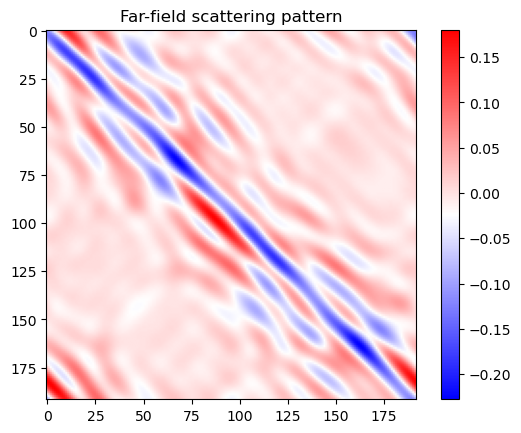

In [53]:
plt.title("Far-field scattering pattern")
plt.imshow(jnp.real(uscat_at_sensors), cmap="bwr")
plt.colorbar()
plt.show()